# A/B Тестирование

Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки. 

Цель проекта: Провести исследование, приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

###### Описание данных

Файл /datasets/hypothesis.csv
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста


## 1. Импортируем библиотеки. Загрузим данные и подготовим их к анализу.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_colwidth', -1)

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visits = pd.read_csv('/datasets/visitors.csv')


In [4]:
df_list = {'Гипотезы':hypothesis, 'Визиты': visits, 'Заказы':orders}
for df in df_list:
    print('Данные таблицы {}'.format(df))
    display(df_list[df].head())
    display(df_list[df].info())
    display(df_list[df].duplicated().sum())

Данные таблицы Гипотезы


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

0

Данные таблицы Визиты


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

0

Данные таблицы Заказы


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

0

Приведем названия столбцов к нижнему регистру и заменим пробел на знак нижнего подчеркивания.

In [5]:
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = ['transaction_id','visitor_id','date','revenue','group']

Заменим типы данных там где это необходимо.

In [6]:
visits['date'] = pd.to_datetime(visits['date'])
orders['date'] = pd.to_datetime(orders['date'])
orders['visitor_id'] = orders['visitor_id'].astype(str)
orders['transaction_id'] = orders['transaction_id'].astype(str)


Проверим корректность теста.

In [7]:
display('Дата начала теста {}'.format(orders['date'].min()))
display('Дата окончания теста {}'.format(orders['date'].max()))

'Дата начала теста 2019-08-01 00:00:00'

'Дата окончания теста 2019-08-31 00:00:00'

Тест проходил на протяжении месяца, с этим все в порядке.

---

Посмотрим на распределение по группам.

In [8]:
ab_totals = orders.groupby('group', as_index=False)['visitor_id'].count()
ab_totals = ab_totals.rename(columns={'visitor_id':'total_users'})
ab_totals

,group,total_users
0,A,557
1,B,640


Группы распределены корректно.

---

Посмотрим нет ли дубликатов.

In [9]:
orders.groupby('visitor_id').agg({'group':'nunique'}).reset_index().query('group > 1').count()

visitor_id    58
group         58
dtype: int64

Некоторые пользователи попали в обе группы одновременно. Это серьезная ошибка, результаты теста могут быть не корректными. Где то на этапе формирования групп тестирования произошла ошибка.

## 2. Приоритизация гипотез.

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [10]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).astype(int)
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1


Наиболее приоритетные по ICE гипотезы 8, 0, 7.

---

Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [11]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'] / hypothesis['efforts']).astype(int)
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40
8,"Запустить акцию, дающую скидку на товар в день рождения",16
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3


Посмотрим, как изменилась приоритизация гипотез при применении RICE вместо ICE.


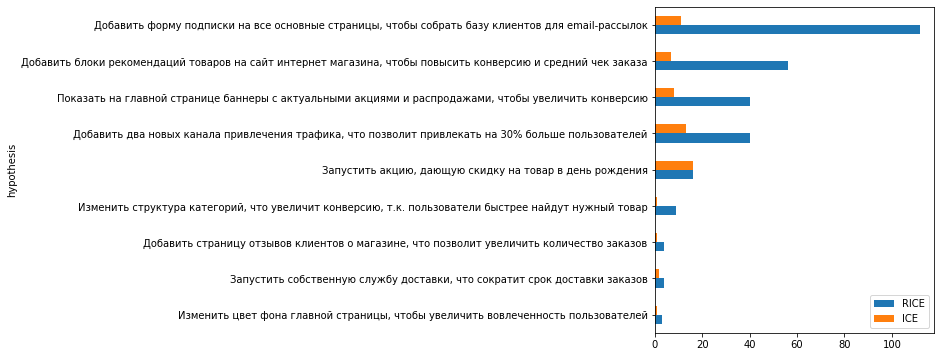

In [12]:
hypothesis.set_index('hypothesis')[['RICE','ICE']].sort_values(by='RICE').plot(kind='barh',figsize=(5,6))
plt.show()

Приоритизация гипотез изменилась при применении RICE вместо ICE за счет параметра Reach, который определяет охват пользователей, которых каснутся изменения:

- Без учета охвата на первом месте идет акция со скидкой имениннику, но параметр Reach справедливо понизил приоритет этой акции, т.к. и правда, охват её минимальный (по сравнению с другими гипотезами увеличения выручки);
- Также произошло и с гипотезой о добавлении 2х каналов трафика, с организацией своей службы доставки и с идеей о добавлении страницы отзывов;
- Без изменений осталась рейтинговая позиция гипотез о добавлении баннеров с актуальными акциями на главную страницу и идея с изменением цвета фона главной страницы);
- Выросли в рейтинге (стали более приоритетными) RICE (по сравнению с ICE) гипотеза о добавлении формы подписки на все основные страницы ресурса, о добавлении блоков рекомендаций товаров и предложение об изменении структуры категорий.

## 3. Анализ A/B-теста

Построим график кумулятивной выручки по группам.

In [13]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': pd.Series.nunique,
            'visitor_id': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visits[
        np.logical_and(
            visits['date'] <= x['date'], visits['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

In [14]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeData['average_revenue'] = cumulativeData['revenue']/cumulativeData['orders']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

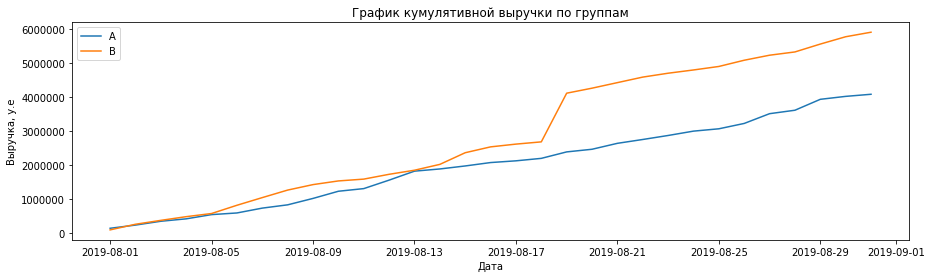

In [15]:
plt.figure(figsize=(15,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['revenue'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['revenue'], label='B')
plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.ylabel('Выручка, y.e')
plt.xlabel('Дата')
plt.show()

На графике видно что начиная с 5 августа выручка двух групп начинает расходится, а 18 августа произошел скачок, возможно аномалия.

----

Построим график кумулятивного среднего чека по группам.

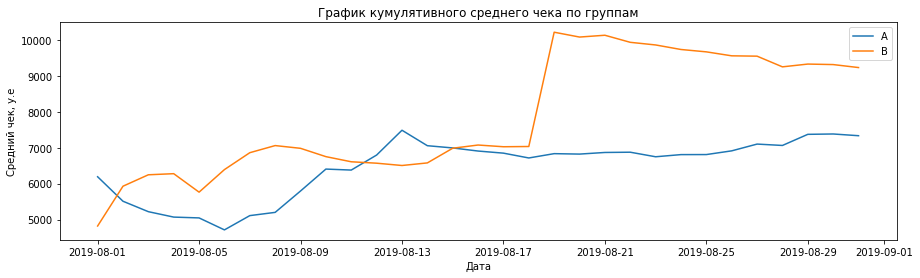

In [16]:
plt.figure(figsize=(15,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['average_revenue'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['average_revenue'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Средний чек, y.e')
plt.xlabel('Дата')
plt.show()

Лидерство по среднему чеку менялось на протяжении половины времени тестирования. На графике так же видно скачек от 18 августа, средний чек группы Б увеличисля на 3к. 

----

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

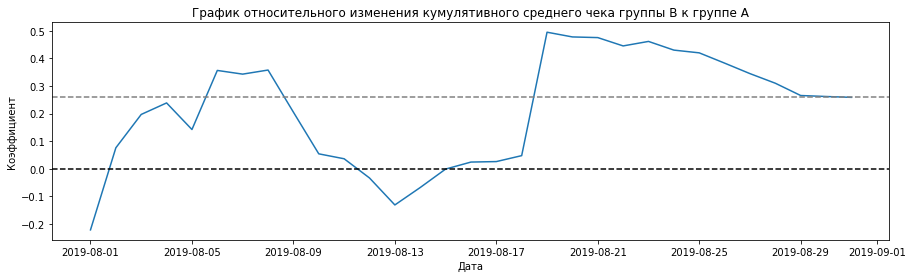

In [17]:
cumulativeDataAB = cumulativeDataA.merge(cumulativeDataB, on='date', how='left', suffixes=['_A', '_B'])
cumulativeDataAB
plt.figure(figsize=(15,4))
plt.plot(cumulativeDataAB['date'], cumulativeDataAB['average_revenue_B']/cumulativeDataAB['average_revenue_A']-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.26, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel('Коэффициент')
plt.xlabel('Дата')
plt.show()


Средний чек группы B, относительно группы A в начале тестирования был то выше, то ниже относительно среднего чека группы A. После скачка 18 августа, средний чек группы B вырос, но постепенно падает.

---

Построим график кумулятивной конверсии по группам.

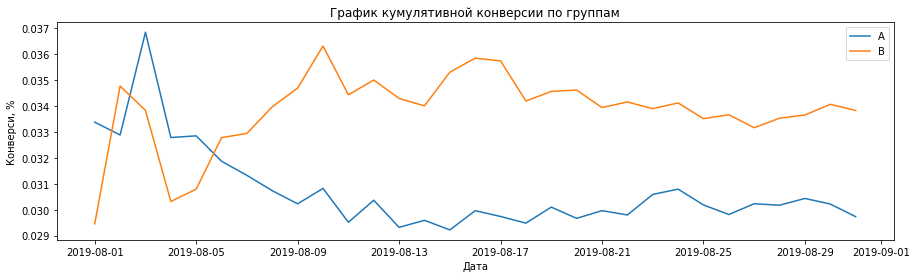

In [18]:
plt.figure(figsize=(15,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивной конверсии по группам')
plt.ylabel('Конверси, %')
plt.xlabel('Дата')
plt.show()


В начале теста график резко скачет для обоих групп, впоследствии группа B вырвалась вперед относительно группы A.

---

Построим график относительного изменения кумулятивной конверсии группы B к группе A. 

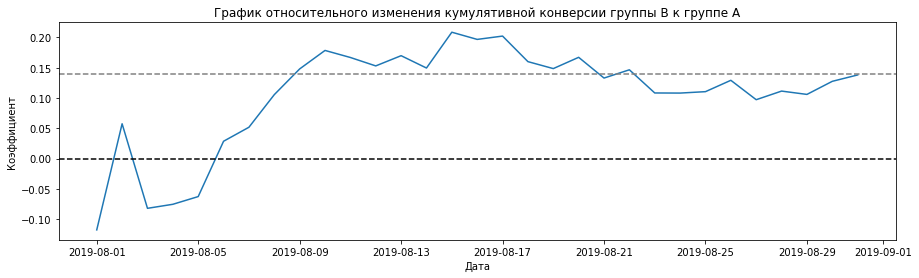

In [19]:
plt.figure(figsize=(15,4))
plt.plot(cumulativeDataAB['date'], cumulativeDataAB['conversion_B']/cumulativeDataAB['conversion_A']-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.ylabel('Коэффициент')
plt.xlabel('Дата')
plt.show()

В начале теста группа B проигрывала группе A, затем вырвалась вперёд. Отношение конверсии группы B установилось и находится выше группы A.

----

Построим точечный график количества заказов по пользователям. Посмотрим на выбросы.

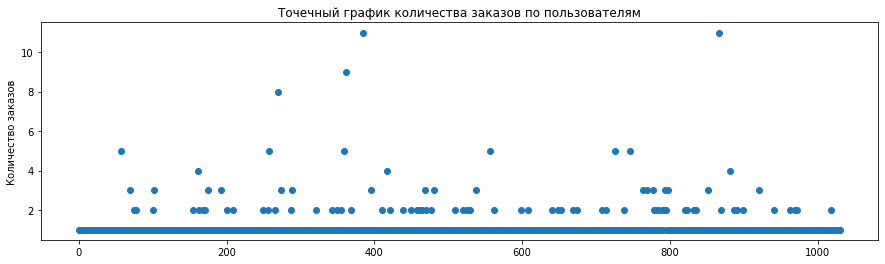

In [20]:
ordersByUsers = (
    orders.drop(['group','revenue','date'], axis=1)
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id':pd.Series.nunique})
    
)
ordersByUsers.columns = ['visitor_id', 'orders']

x_values = pd.Series(range(0,len(ordersByUsers['orders'])))
plt.figure(figsize=(15,4))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Точечный график количества заказов по пользователям')
plt.ylabel('Количество заказов')
plt.show()

На графике видно, что есть аномальные пользователи с большим количеством заказов.

---

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [21]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

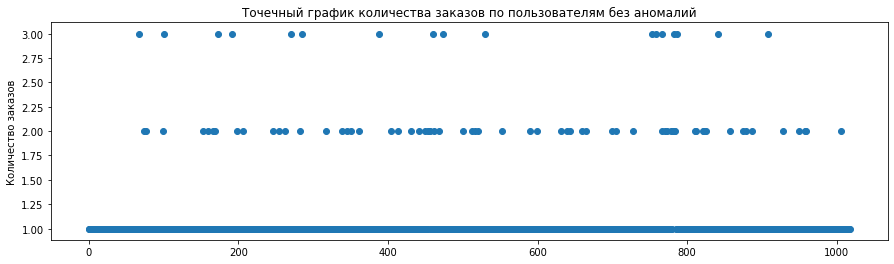

In [22]:
x_values = pd.Series(range(0,len(ordersByUsers[ordersByUsers['orders'] < 4]['orders'])))
plt.figure(figsize=(15,4))
plt.scatter(x_values, ordersByUsers[ordersByUsers['orders'] < 4]['orders']) 
plt.title('Точечный график количества заказов по пользователям без аномалий')
plt.ylabel('Количество заказов')
plt.show()

Будем считать аномалиями пользователей, которые совершили больше 3 заказов.

---

Построим точечный график стоимостей заказов.

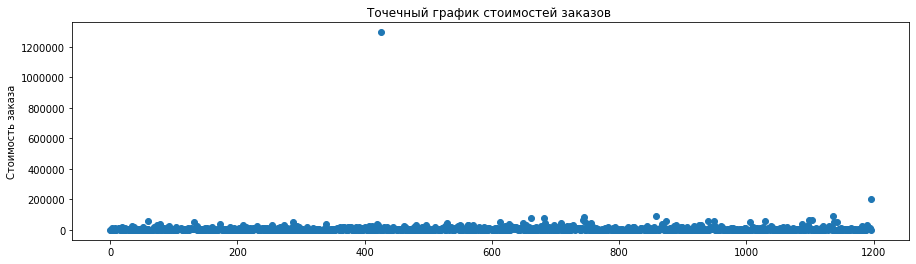

In [23]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,4))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечный график стоимостей заказов ')
plt.ylabel('Стоимость заказа')
plt.show()

В данных есть не типичные заказы с очень большой стоимостью.

---

Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [24]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

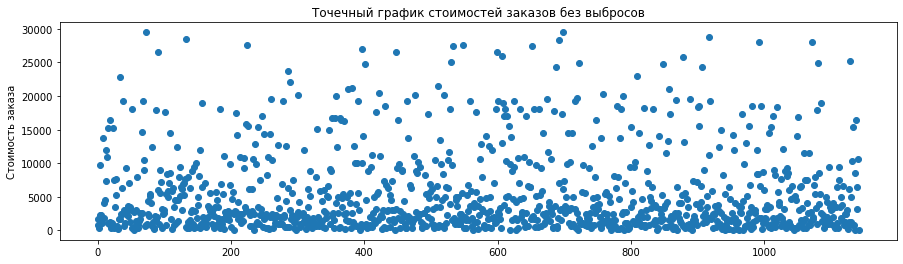

In [25]:
x_values = pd.Series(range(0,len(orders[orders['revenue'] < 30000]['revenue'])))
plt.figure(figsize=(15,4))
plt.scatter(x_values, orders[orders['revenue'] < 30000]['revenue']) 
plt.title('Точечный график стоимостей заказов без выбросов')
plt.ylabel('Стоимость заказа')
plt.show()

Возьмем за границу для определния аномальных заказов 30000.

----

## 4. Статистическая значимость различий  между группами.

Здесь и далее будем считать:
 * Нулевая гитореза H0 : между группами статистически значимых различий нет
 * Альтернативная гипотеза H1 :  данные между группами статистически значимо различаются
 * Примем для себя уровень значимости alpha = .05
 
---

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.

In [26]:

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['user_id', 'orders']
 
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['user_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visits[visits['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
 
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visits[visits['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("P-Value: {0:.3f}".format(st.mannwhitneyu(sampleA,
                                                sampleB, True, 'two-sided')[1]))
print('Относительное различие в конверсии между группами B и A : {0:.1%}'.format(
    sampleB.mean() 
    /sampleA.mean() - 1))
print('Средняя конверсия группы А: {:.1%}'.format(sampleA.mean()))
print('Средняя конверсия группы B: {:.1%}'.format(sampleB.mean()))

P-Value: 0.017
Относительное различие в конверсии между группами B и A : 13.8%
Средняя конверсия группы А: 3.0%
Средняя конверсия группы B: 3.4%


P-value < 0.05. Отвергаем нулевую гипотезу. Есть статистически значимые различия в конверсии между группами. Относительное отличие группы B равно 13.8%.

----

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.


In [27]:
print('P-value: {0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                                orders[orders['group']=='B']['revenue'], True, 'two-sided')[1]))
print('Относительное различие среднего чека заказа между группами B и A : {0:.1%}'.format(
    orders[orders['group']=='B']['revenue'].mean()
    /orders[orders['group']=='A']['revenue'].mean()-1)) 
print('Средний чек группы А: {:.2f}'.format(orders[orders['group']=='A']['revenue'].mean()))
print('Средний чек группы B: {:.2f}'.format(orders[orders['group']=='B']['revenue'].mean()))

P-value: 0.729
Относительное различие среднего чека заказа между группами B и A : 25.9%
Средний чек группы А: 7333.58
Средний чек группы B: 9230.88


P-value = 0.729 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке между группами нет, не отвергаем. Однако относительное отличие группы B от A равно 25.9%, это связано с аномалиями.

---

Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.


In [28]:
anomal_orders = ordersByUsers[ordersByUsers['orders'] > 3]
filtered_orders = orders.query('revenue < 30000 and visitor_id not in @anomal_orders.visitor_id')


ordersA_clean = (
    filtered_orders[filtered_orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersA_clean.columns = ['user_id', 'orders']
 
ordersB_clean = (
    filtered_orders[filtered_orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersB_clean.columns = ['user_id', 'orders']

sampleA_clean = pd.concat(
    [
        ordersA_clean['orders'],
        pd.Series(
            0,
            index=np.arange(
                visits[visits['group']=='A']['visitors'].sum() - len(ordersA_clean['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
 
sampleB_clean = pd.concat(
    [
        ordersB_clean['orders'],
        pd.Series(
            0,
            index=np.arange(
                visits[visits['group']=='B']['visitors'].sum() - len(ordersB_clean['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("P-Value: {0:.3f}".format(st.mannwhitneyu(sampleA_clean,
                                                sampleB_clean, True, 'two-sided')[1]))
print('Относительное различие в конверсии между группами B и A : {0:.1%}'.format(
    sampleB_clean.mean() 
    /sampleA_clean.mean() - 1))
print('Средняя конверсия группы А: {:.1%}'.format(sampleA_clean.mean()))
print('Средняя конверсия группы B: {:.1%}'.format(sampleB_clean.mean()))

P-Value: 0.020
Относительное различие в конверсии между группами B и A : 14.5%
Средняя конверсия группы А: 2.6%
Средняя конверсия группы B: 3.0%


Значение p-value все еще меньше 0.05. Конверсия в двух группах различается статистически значимо. Относительное отличие стало чуть более выраженным.

---

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [30]:
print('P-value: {0:.3f}'.format(st.mannwhitneyu(filtered_orders[filtered_orders['group']=='A']['revenue'],
                                                filtered_orders[filtered_orders['group']=='B']['revenue'],
                                                True,
                                                'two-sided')[1]))
print('Относительное различие среднего чека заказа между группами B и A : {0:.1%}'.format(
    filtered_orders[filtered_orders['group']=='B']['revenue'].mean()
    /filtered_orders[filtered_orders['group']=='A']['revenue'].mean()-1)) 
print('Средний чек группы А: {:.2f}'.format(filtered_orders[filtered_orders['group']=='A']['revenue'].mean()))
print('Средний чек группы B: {:.2f}'.format(filtered_orders[filtered_orders['group']=='B']['revenue'].mean()))

P-value: 0.709
Относительное различие среднего чека заказа между группами B и A : -3.8%
Средний чек группы А: 5433.93
Средний чек группы B: 5229.08


P-value = 0.354 больше 0.05. Статистически значимых различий в среднем чеке между группами нет. Cредние чеки значительно выровнялись, больше нет такой большой разницы между группа А и В по среднему чеку. Относительное отличие группы B от A изменилось и равно 3.8%, что подтверждает предыдущий вывод по относительным различиям в сырых данных из-за аномалий. 

---

## 5. Решение по результатам теста.

Приоритизация гипотез изменилась при применении RICE вместо ICE за счет охвата пользователей, которых каснутся изменения.
На первое место в рейтинге вышла гипотеза о добавлении формы подписки на все основные страницы ресурса, на второе о добавлении блоков рекомендаций товаров и предложение об изменении структуры категорий.

В данных были аномальные пользователи, мы эти аномалии обработали и получили следующий результат:
- по конверсии между группами A и B (как по сырым данным, так и по очищенным) есть статистически значимые различия;
- по среднему чеку между группами A и B (как по сырым данным, так и по очищенным) нет статистически значимых различий.

Рекомендуется остановить тест. Тест прошел с грубым нарушением, на этапе распределения групп произошла ошибка, в обе группы попали одни и те же пользователи. Следует сообщить разработчикам чтобы они выявили причину и поправили систему распределения пользователей по группам, а так же провести новый тест без этих нарушений.

По результатам прошедшего теста можно сделать вывод, что мы смогли увеличить выручку, за счет увеличения конверсии в группе B на **14,5%**. Различий в среднем чеке не зафиксированно. 
